In [1]:
from os import listdir
import os
import numpy as np
from PIL import Image
import json
import skimage.draw
import matplotlib.pyplot as plt

from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.utils import compute_ap
from mrcnn.utils import extract_bboxes
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image


Using TensorFlow backend.


In [2]:
class Region:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def bbox(self):
        coords = [min(self.x), min(self.y), max(self.x), max(self.y)]
        return coords

In [3]:
with open("sample_file.json","r") as json_file:
        json_data = json.load(json_file)

In [4]:
json_data = json_data['_via_img_metadata']


In [5]:
fileinfo = dict() # value is a list of "region"s

for file in json_data.values():
    key = file['filename'][0:-4]
    regions = file['regions']
    value = []
    for r in regions:
        rdict = r['region_attributes']['Malaria_affected_area']
        if 'Malaria_affected_area' in rdict:
            if rdict['Malaria_affected_area']:
                 fileinfo[key] = r['shape_attributes']
                    

In [6]:
class Malaria_cellDataset(Dataset):
  
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "malaria_infected_cell")
        # define data locations
        images_dir = dataset_dir
        image_id = 0
        # find all images
        for filename in listdir(images_dir):
            # extract image id
            image_id = image_id + 1
            #print(image_id)
            img_path = images_dir + '/' +filename
            img = Image.open(img_path)
            width, height = img.size
            fname = filename[0:-4]
            if is_train and int(image_id) >= 80:
                continue
            if not is_train and int(image_id) < 80:
                continue
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, width=width, height=height, polygons=fileinfo[fname])
            
    
    def extract_boxes(self, image_id):
        info = self.image_info[image_id]
        return info['polygons'], info['width'], info['height']
    

    # load the masks for an image
    def load_mask(self, image_id):
        boxes, w, h = self.extract_boxes(image_id)
        #print(boxes)
        # create one array for all masks, each on a different channel
        
        image_info = self.image_info[image_id]
        masks = np.zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i, p in enumerate(image_info['polygons']):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(image_info['polygons']['all_points_y'], image_info['polygons']['all_points_x'])
            masks[rr, cc, i] = 1
            class_ids.append(self.class_names.index('malaria_infected_cell'))
        return masks, np.asarray(class_ids, dtype='int32')
    
   # train set
train_set = Malaria_cellDataset()
train_set.load_dataset('cell_images_infected', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
# test/val set
test_set = Malaria_cellDataset()
test_set.load_dataset('cell_images_infected', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 79
Test: 28


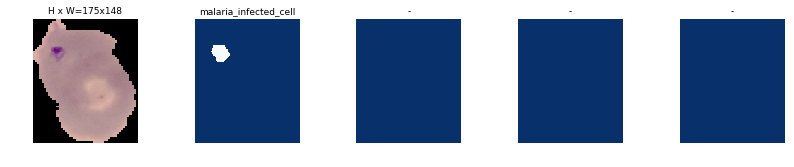

In [9]:
image_id = 40
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids,train_set.class_names)

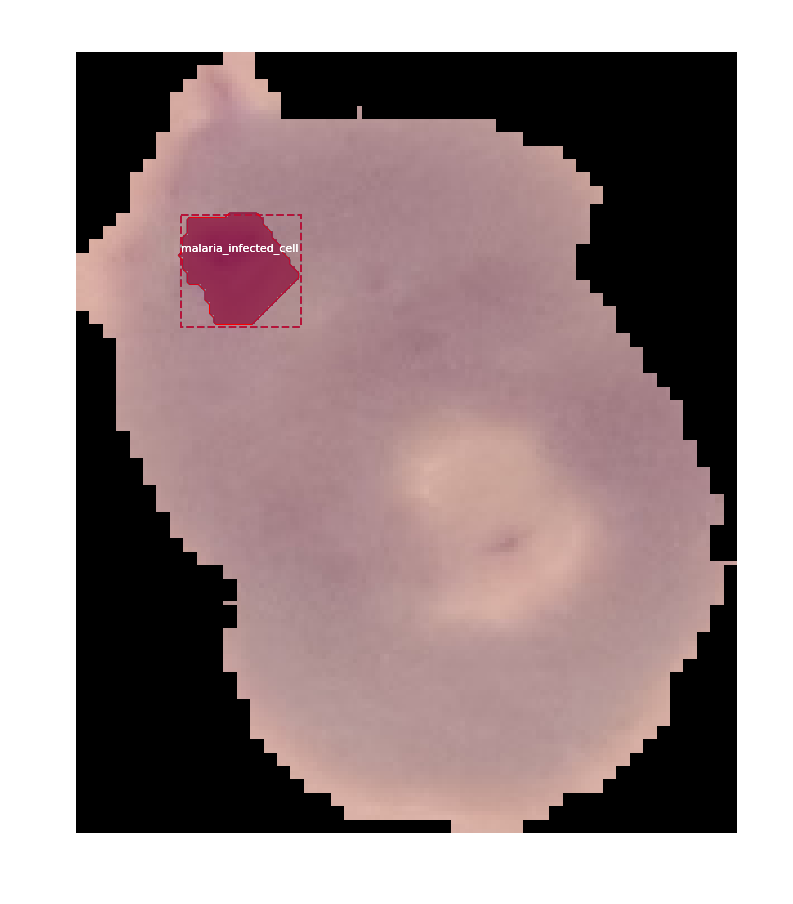

In [10]:
bbox = extract_bboxes(mask)
visualize.display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [11]:
class CellConfig(Config):
    # define the name of the configuration
    NAME = 'cell_cfg'
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # number of training steps per epoch
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    pass
 
# prepare config
config = CellConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [13]:
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./cell_cfg20190726T2001/mask_rcnn_cell_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDis

/home/snarva/.conda/envs/deep/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/snarva/.conda/envs/deep/lib/python3.6/site-packages/keras/engine/training_generator.py:46: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
1000/1000 [==============================] - 395s 395ms/step - loss: 0.6948 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1445 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.2378 - mrcnn_mask_loss: 0.2746 - val_loss: 1.9144 - val_rpn_class_loss: 0.0201 - val_rpn_bbox_loss: 0.8852 - val_mrcnn_class_loss: 0.0566 - val_mrcnn_bbox_loss: 0.3287 - val_mrcnn_mask_loss: 0.6240
Epoch 2/5
1000/1000 [==============================] - 373s 373ms/step - loss: 0.2874 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0466 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0611 - mrcnn_mask_loss: 0.1612 - val_loss: 1.9233 - val_rpn_class_loss: 0.0102 - val_rpn_bbox_loss: 0.5933 - val_mrcnn_class_loss: 0.0746 - val_mrcnn_bbox_loss: 0.3445 - val_mrcnn_mask_loss: 0.9008
Epoch 3/5
1000/1000 [==============================] - 369s 369ms/step - loss: 0.1879 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.1149 - val_loss: 1.9332 - val

In [15]:
class TestConfig(Config):
    # define the name of the configuration
    NAME = 'cell_cfg'
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # number of training steps per epoch
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    pass
 
# prepare config
config1 = TestConfig()
config1.display()

model = MaskRCNN(mode="inference", model_dir='./', config=config1)
model.load_weights('cell_cfg20190726T2001/mask_rcnn_cell_cfg_0005.h5', by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [16]:
def get_ax(rows=1, cols=1, size=16):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  204.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   80.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


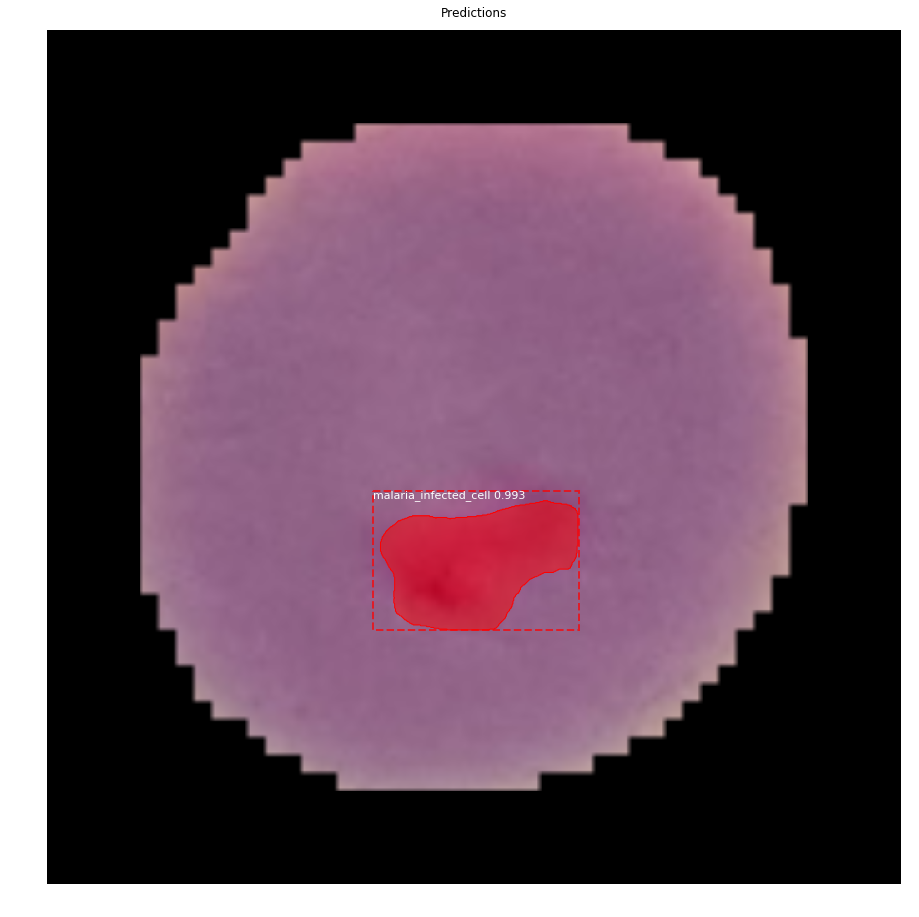

In [31]:
image_id = 15
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    load_image_gt(test_set, config, image_id, use_mini_mask=False)
info = test_set.image_info[image_id]
results = model.detect([image], verbose=1)

ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], ax=ax,
                            title="Predictions")